# Assignment — Epidemics on graphs

In [51]:
import networkx as nx
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt

### Task 1. SIS on networks (2 points)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [52]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [53]:
def sis_networks(G, S, I, beta, gamma, k):
    result = [[S, I]]
    A = nx.to_numpy_array(G)
    for _ in range(k):
      infected_neighbors_number = I.dot(A) * S
      dI = select_nodes(infected_neighbors_number, beta)
      dS = select_nodes(I, gamma)
      I = I + dI - dS
      S = 1 - I
      result.append([S, I])
    return np.array(result)

In [54]:
G = nx.barabasi_albert_graph(30, 2, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 3030
assert epidemic.shape == (101, 2, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 3030
assert 8.2271 < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < 15.8452
assert 14.2177 < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < 21.7279

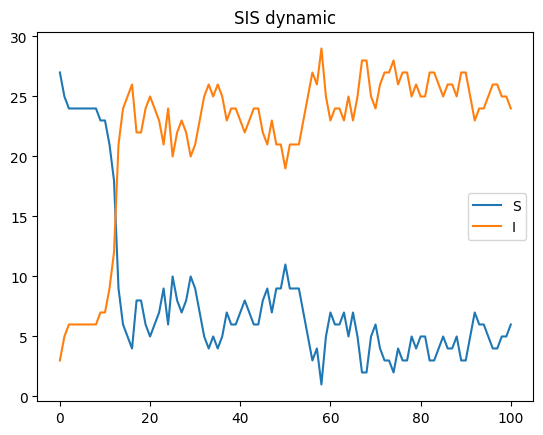

In [55]:
epidemic = sis_networks(
    G, S, I, beta=0.1, gamma=0.05, k=100)
plt.plot(epidemic.sum(axis=2))
plt.title('SIS dynamic')
plt.legend(['S', 'I']);

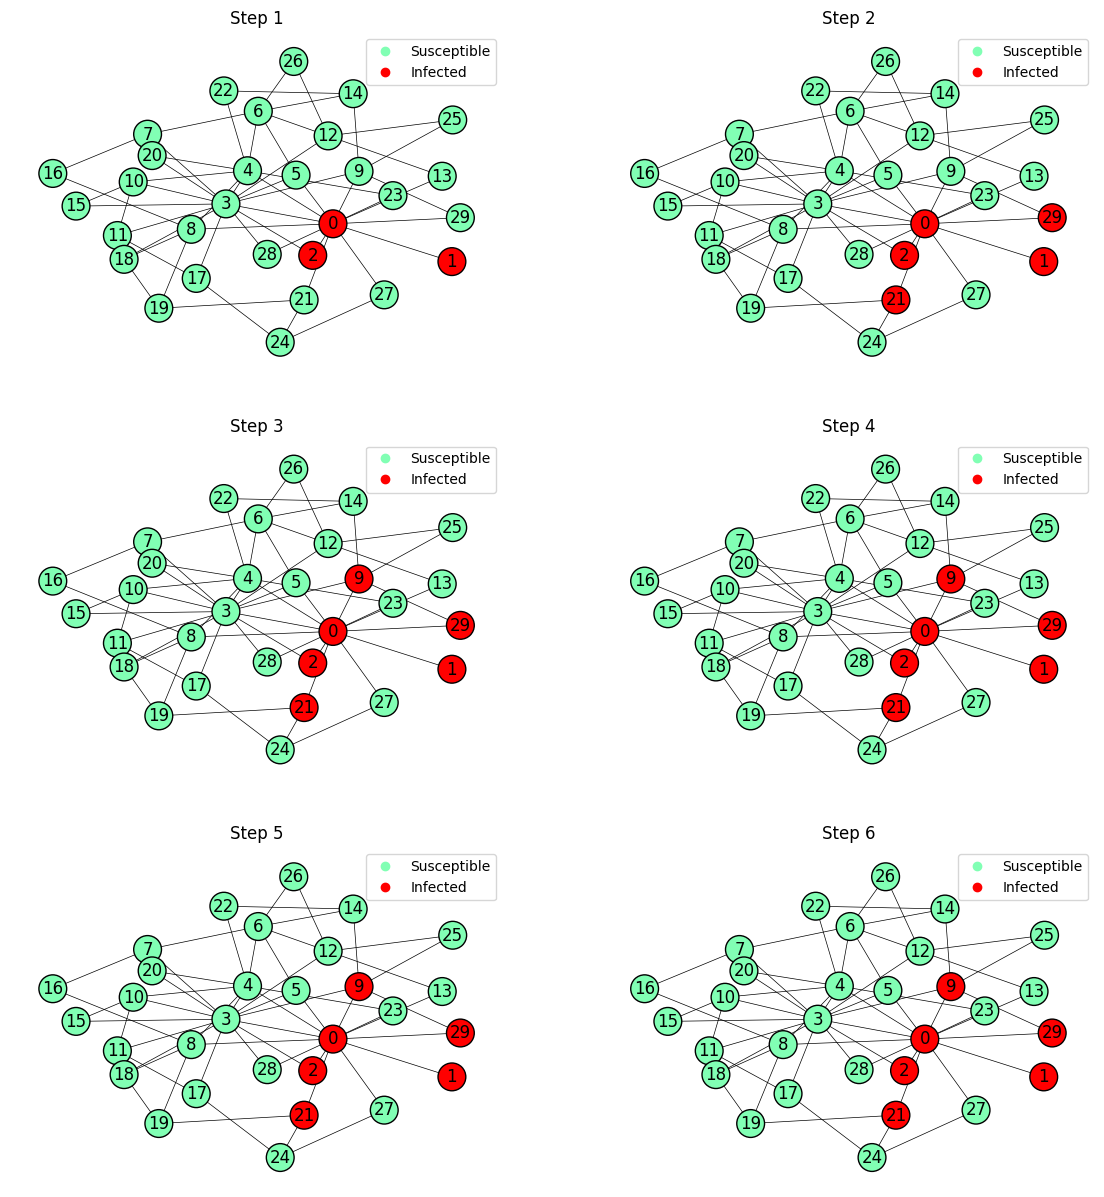

In [56]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 2. SIRS on networks (2 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [57]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    result = [[S, I, R]]
    A = nx.to_numpy_array(G)
    for i in range(1, k+1):
      S_prev, I_prev, R_prev = result[-1]
      delt_R = select_nodes(I_prev, gamma)
      I_next = I_prev + select_nodes(I_prev @ A * S_prev, beta) - delt_R
      R_next = R_prev + delt_R - select_nodes(R_prev, delta)
      S_next = 1 - (R_next + I_next)
      result.append([S_next, I_next, R_next])
    return np.array(result)

In [58]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, beta=0.1, gamma=0.05, delta=0.01, k=1000)
assert epidemic.shape == (1001, 3, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 1001 * 30
assert np.all(epidemic[0].sum(axis=1) == (27, 3, 0))
assert np.all(epidemic[-1].sum(axis=1) == (30, 0, 0))
assert epidemic[0:20, 2].sum() > 0

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

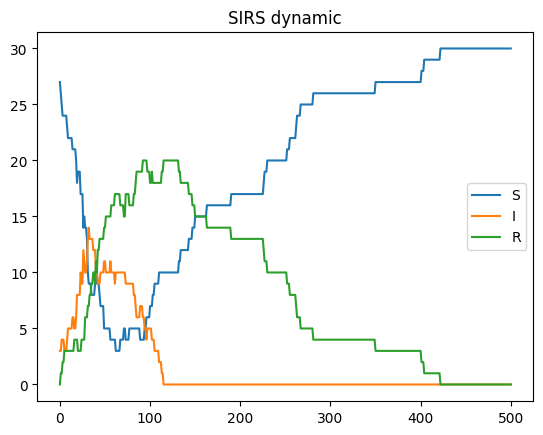

In [59]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.05, gamma=0.03, delta=0.01, k=500)
plt.plot(epidemic.sum(axis=2))
plt.title('SIRS dynamic')
plt.legend(['S', 'I', 'R']);

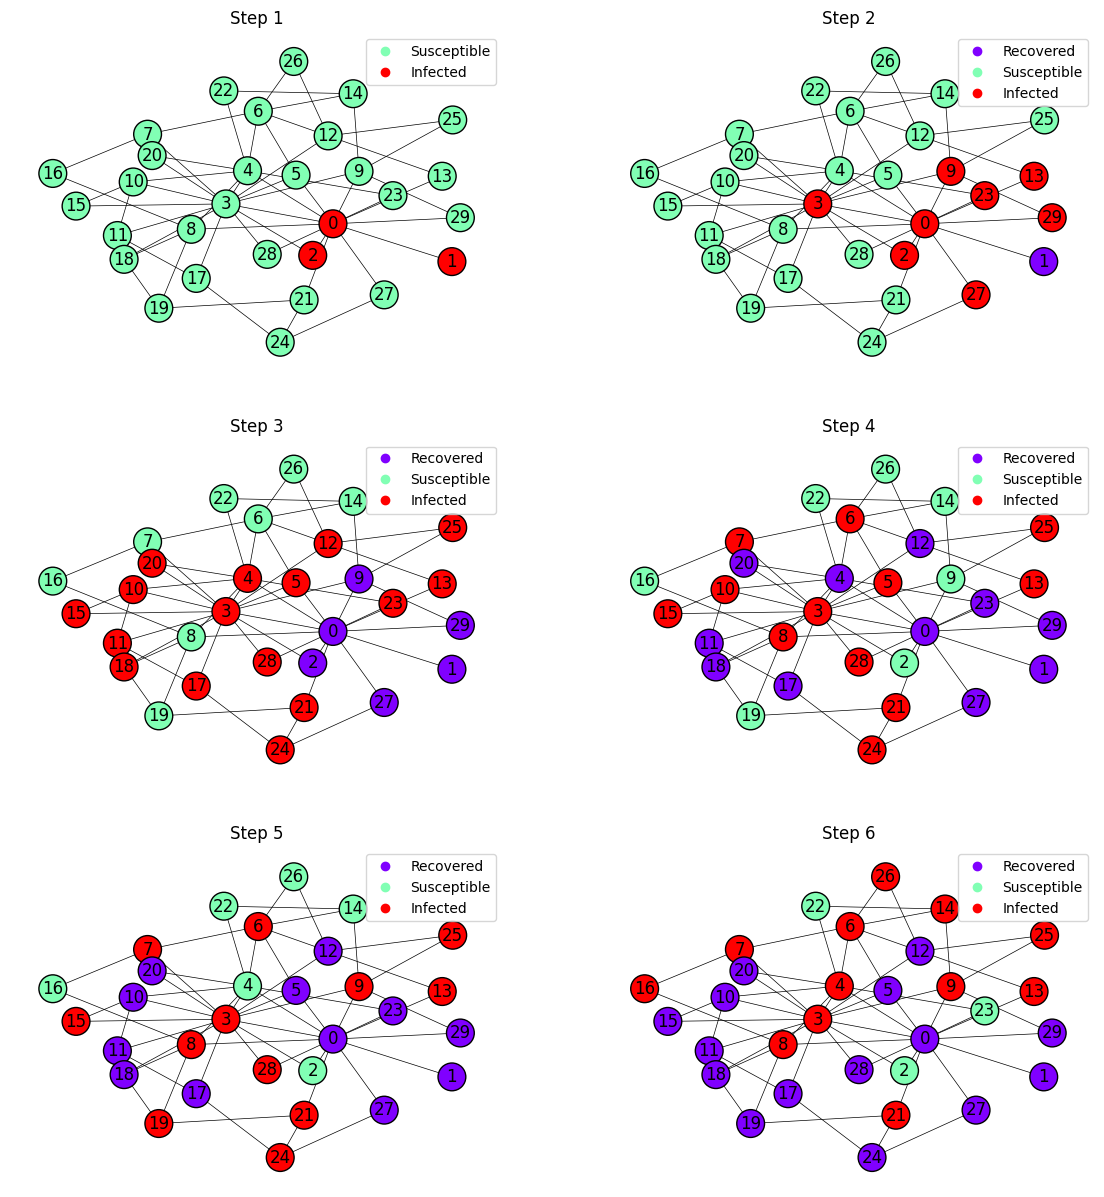

In [60]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.5, gamma=0.3, delta=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 3. Random immunization in SIS (2 points)

Immunization strategies specify how vaccines, treatments or drugs are distributed in the population. Ideally, should a treatment or vaccine exist, it should be given to every infected individual or those at risk of contracting the pathogen. However, it is costly to vaccinate all risky people. Given these constraints, immunization strategies aim to minimize the threat of a pandemic by most effectively distributing the available vaccines or treatments. Let us see how different vaccination strategies affect epidemics under SIS model on netwoks.

Random immunization in the network means isolation of randomly selected nodes, that is removing all their adjacent edges. Write a function `random_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [61]:
def random_immunization_sis(G, S, I, share, beta, gamma, k):
    immune_nodes = np.random.choice(G.nodes(), size=int(len(G) * share), replace=False)
    Gc = G.copy()
    for node in immune_nodes:
      Gc.remove_edges_from(list(Gc.edges(node)))
    return immune_nodes, sis_networks(Gc, S, I, beta, gamma, k)

In [62]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=1.0, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 30
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.0, beta=0.2, gamma=0.1, k=1)
assert immune_nodes.shape[0] == 0
unique_nodes = set()
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.1, beta=0.2, gamma=0.1, k=1)
    unique_nodes = unique_nodes.union(immune_nodes)
assert len(unique_nodes) == 30
G = nx.complete_graph(4)
I = np.array([1, 0, 0, 0])
S = 1 - I
n_infected = []
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.25, beta=1.0, gamma=0.0, k=1)
    if 0 in immune_nodes:
        assert epidemic[-1, 1].sum() == 1
    else:
        assert epidemic[-1, 1].sum() == 3

Let us see how the random immunization works on networks.

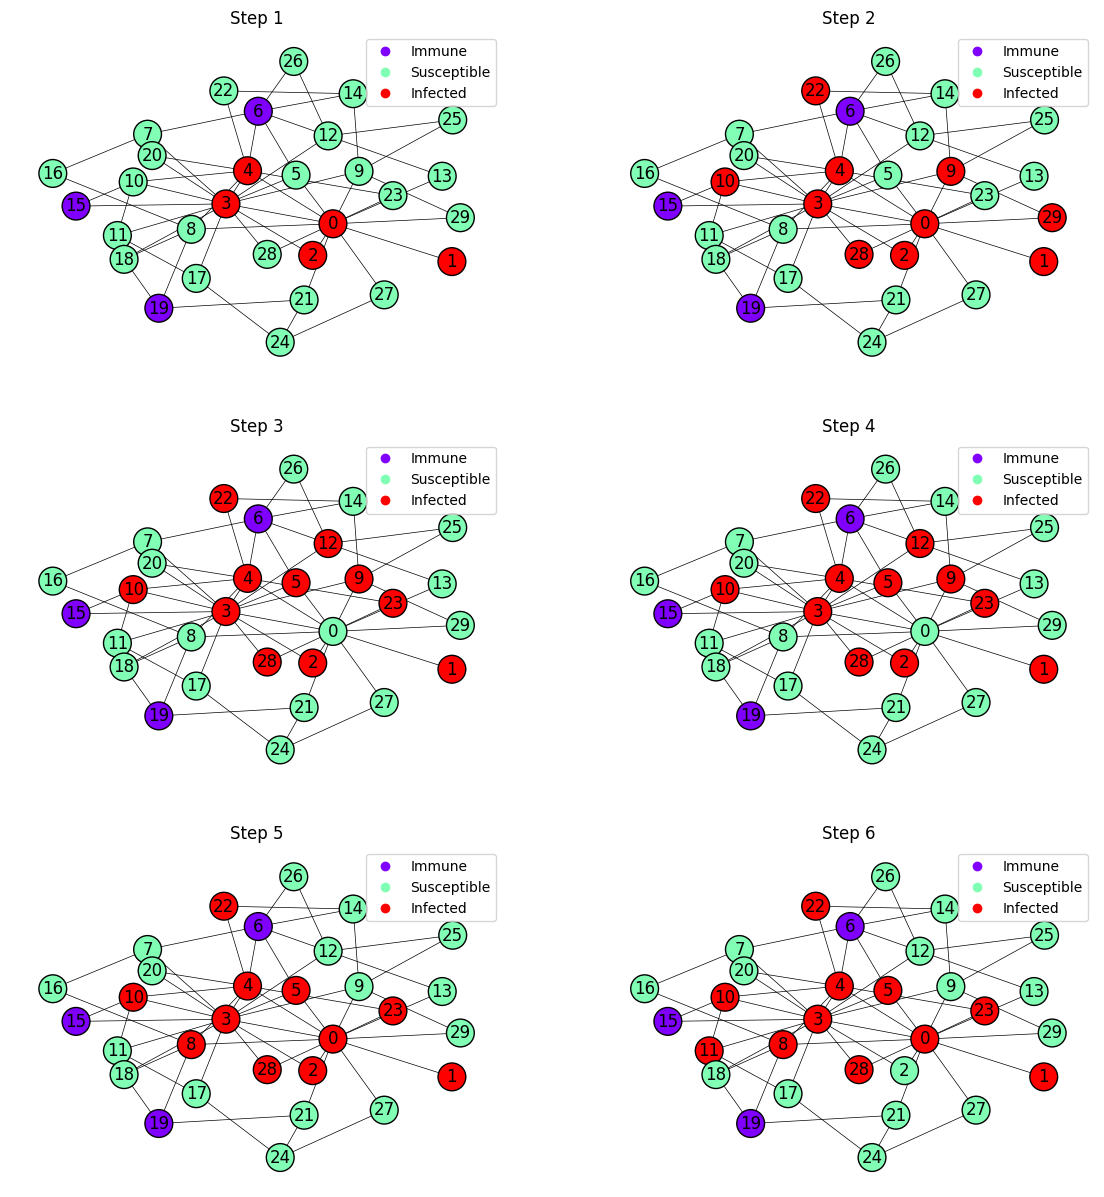

In [63]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

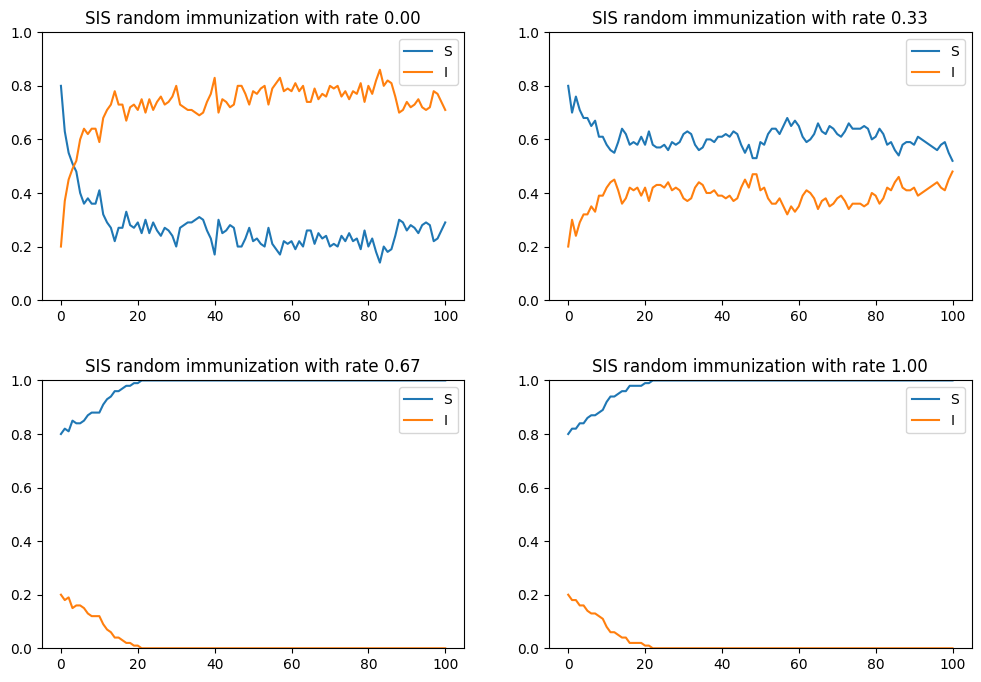

In [64]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = random_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 4. Selective immunization in SIS (2 points)

Selective immunization is a strategy to select some important persons to be vaccinated. Let they be the most "famous" people.

Selective immunization in the network means isolation of highest degree nodes, that is removing all their adjacent edges. Write a function `selective_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [93]:
def selective_immunization_sis(G, S, I, share, beta, gamma, k):
    # YOUR CODE HERE
    immune_nodes = np.random.choice(G.nodes(), size=int(len(G) * share), replace=False)
    graph = nx.Graph(G.copy())
    new_nodes = graph.nodes
    degree_list=sorted(G.degree, key=lambda x: x[1], reverse=True)
    edge = []
    count=0

    for i in degree_list:
      if count == len(immune_nodes):
        break    
      edge.append(list(graph.edges(i[0])))
      count += 1



    for node in immune_nodes:
      graph.remove_edges_from(list(graph.edges(node)))
    return immune_nodes, sis_networks(graph, S, I, beta, gamma, k)



    
    





  
  
  

In [94]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.5, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert np.sum(sorted(nx.to_numpy_array(G).sum(axis=1), reverse=True)[:15]) \
    == nx.to_numpy_array(G)[immune_nodes].sum()

AssertionError: ignored

Let us see how the selective immunization works on networks.

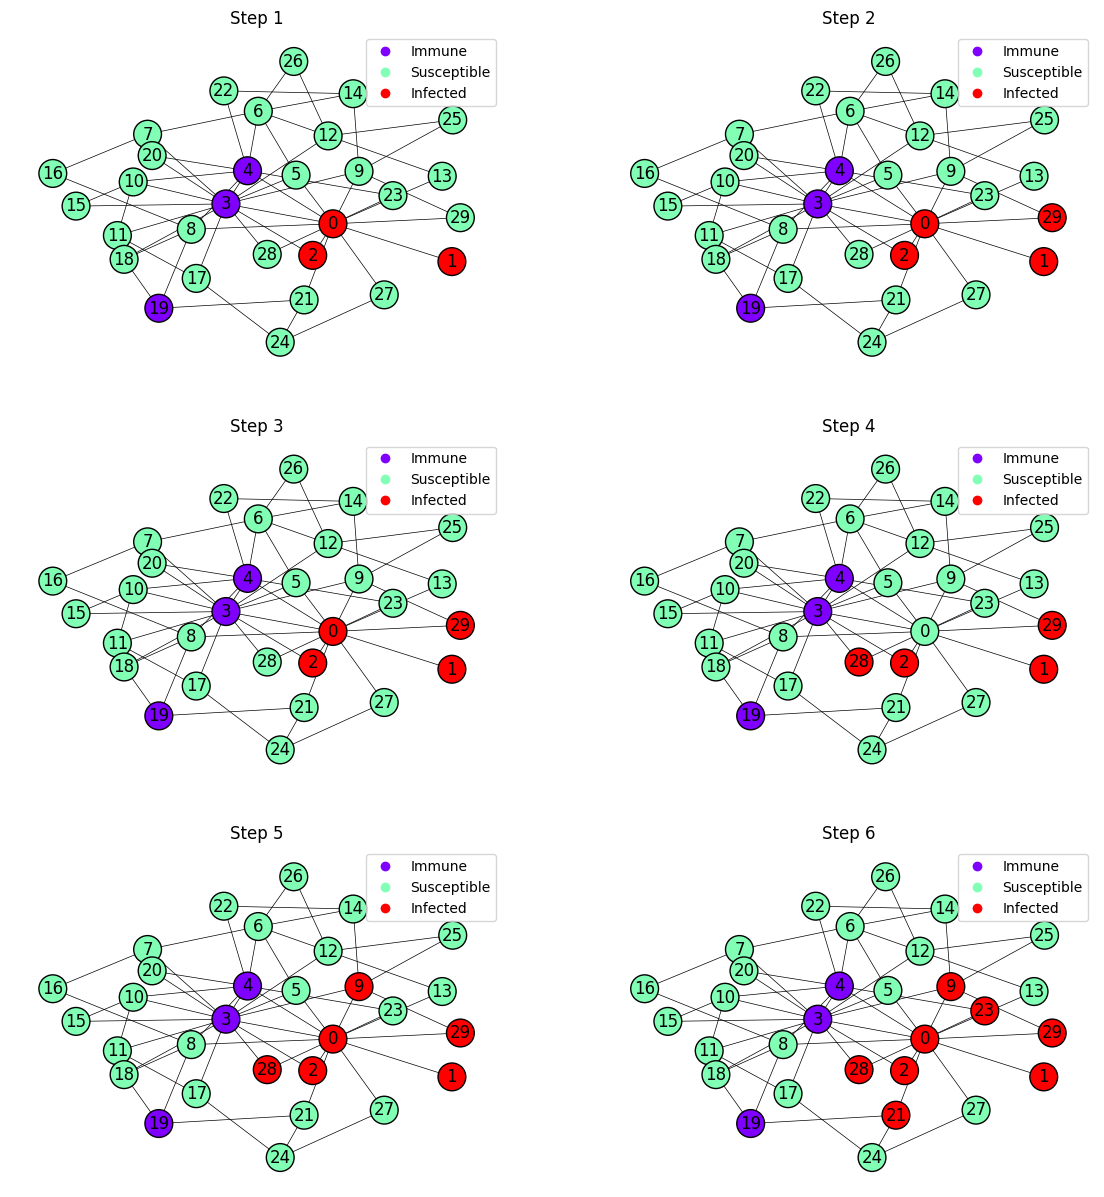

In [95]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

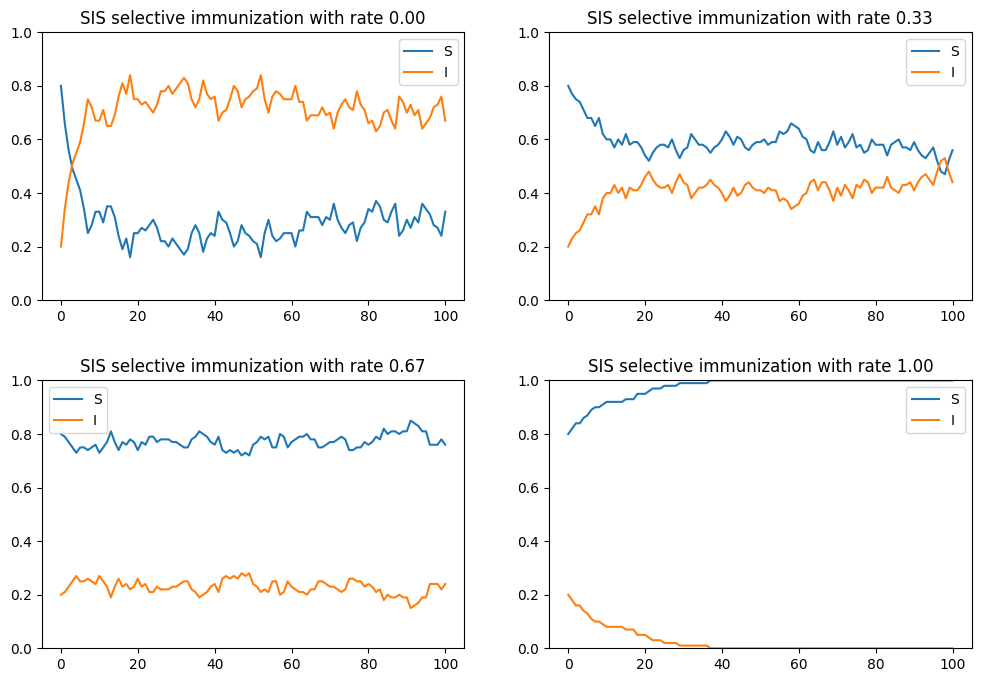

In [96]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = selective_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS selective immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 5. Self-isolation strategy in SIS (2 points)

Self-isolation is close to the random immunization — we make some individuals invisible to the virus for a period.

Self-isolation in the network means isolation of some random nodes, that is removing all their adjacent edges for a period and then recover deleted edges. Write a function `self_isolation_sis` that takes the share of nodes `share`, period of self-isolation `period`, parameters of SIS model and returns a tuple:
* list of self-isolated nodes
* SIS model output

Do not change the input graph.

In [97]:
def self_isolation_sis(G, S, I, share, period, beta, gamma, k):
    # YOUR CODE HERE

    immune_nodes = np.random.choice(G.nodes(), size=int(len(G) * share), replace=False)
    graph = nx.Graph(G.copy())
    new_nodes = graph.nodes
    degree_list=sorted(G.degree, key=lambda x: x[1], reverse=True)
    edge = []
    for i in range(0,len(immune_nodes)):
      node = np.random.choice(new_nodes)
      edge.extend(list(graph.edges(node)))

    graph.remove_edges_from(edge)
    answer = sis_networks(graph,S, I, beta, gamma, period)  
    graph.add_edges_from(edge)
    answer_1 = sis_networks(graph,S, I, beta, gamma, k-period)

    result = np.append(answer,answer_1,axis=0)
    return immune_nodes,np.array(result)  


    

    
    

In [98]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.5, period=10, beta=0.2, gamma=0.1, k=100)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert epidemic.shape == (101, 2, 30)
epidemic_i = epidemic[:, 1].sum(axis=1)
assert epidemic_i[:11].mean() * 2 < epidemic_i[12:].mean()

AssertionError: ignored

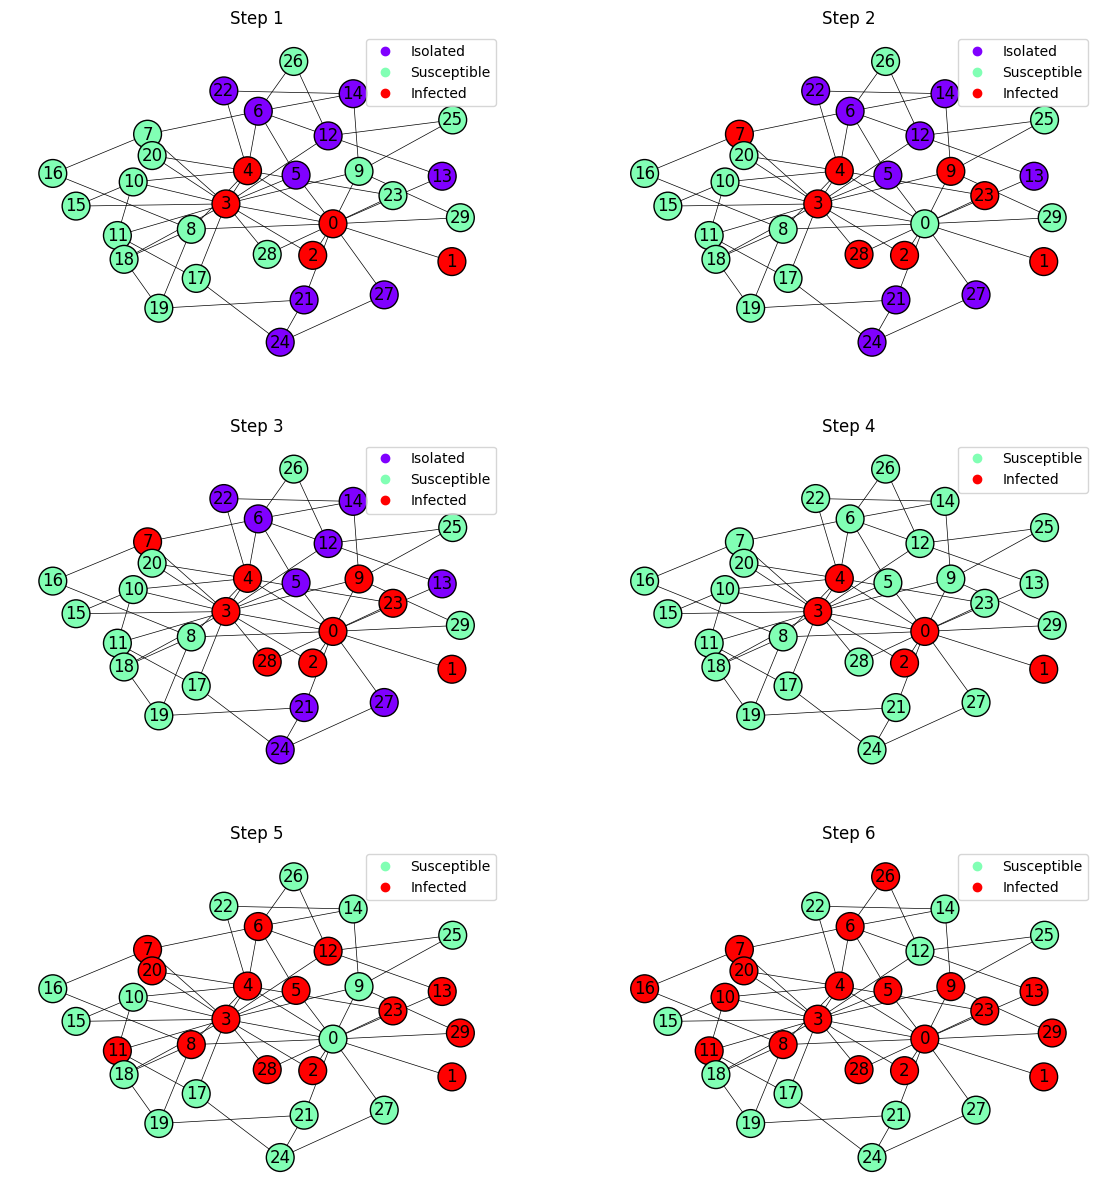

In [99]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.3, period=2, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for step, (S, I) in enumerate(epidemic[:6]):
    colors = I + 1
    legend = ['Susceptible', 'Infected']
    if step < 3:
        colors[immune_nodes] = -1
        legend = ['Isolated', 'Susceptible', 'Infected']
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], legend)
    plt.axis('off')
    i += 1

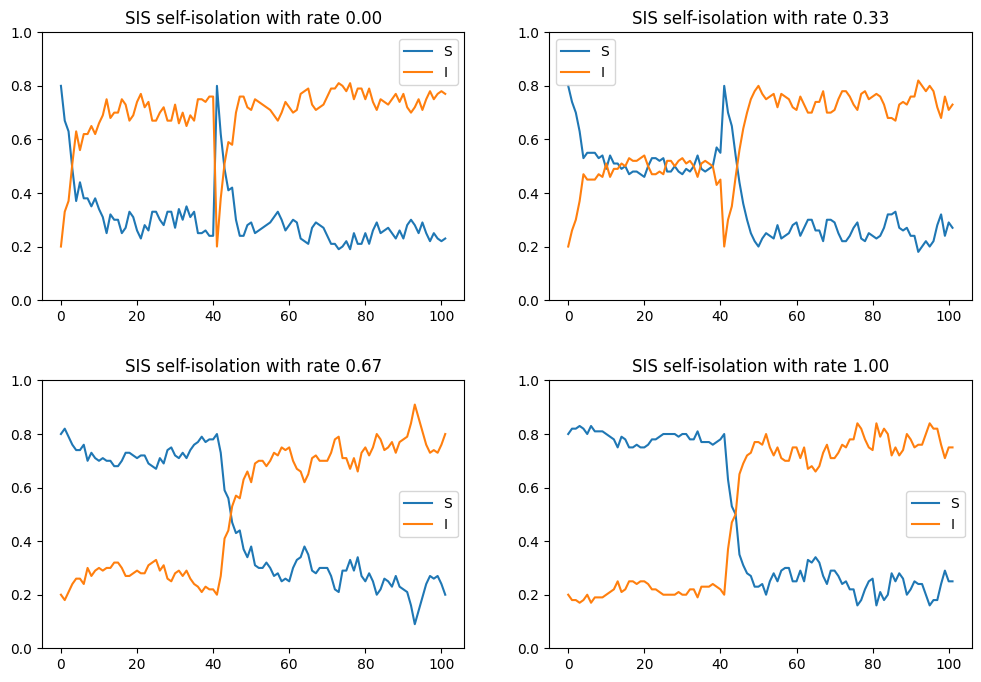

In [100]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share, period=40, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

Here we can see that high self-isolated rate of population delays a case when all people to be infected.

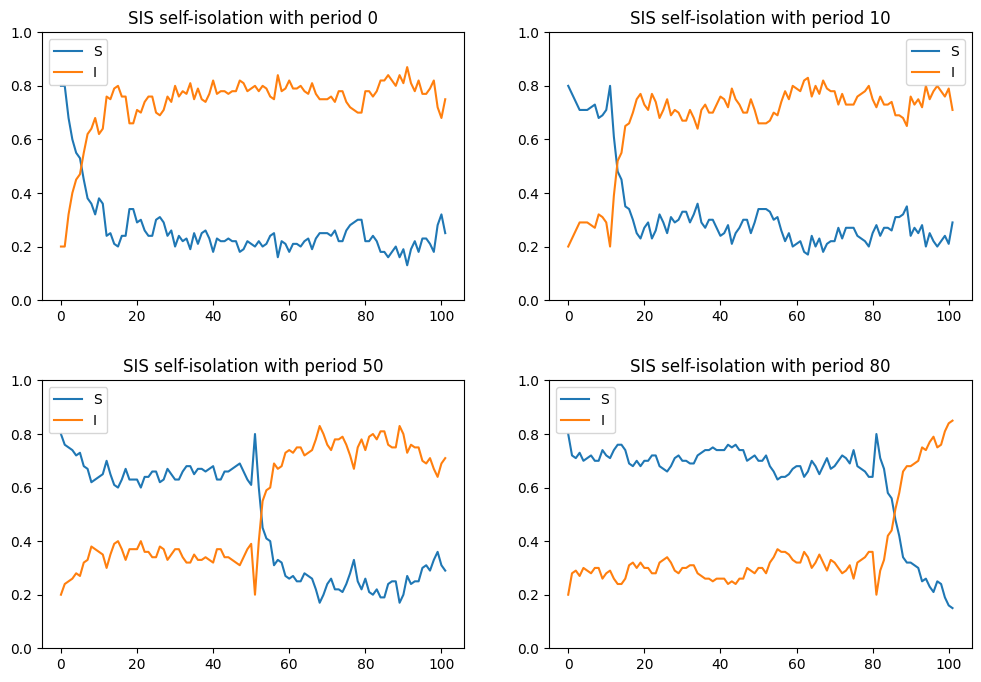

In [101]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for period in [0, 10, 50, 80]:
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share=0.6, period=period, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with period {period}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)